In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import contractions
import torch
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder

In [2]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rudyferreira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rudyferreira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### initial data treatment and visualization
transforming into pandas dataframe, removing upper case letters and punctuation, visualizing distribution

In [4]:
dataset = load_dataset("QuotaClimat/frugalaichallenge-text-train")
df = pd.DataFrame(dataset['train'])

<AxesSubplot:xlabel='label'>

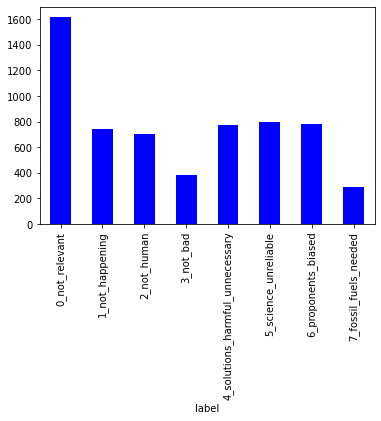

In [5]:
df.groupby('label').quote.count().plot.bar(color = 'blue')

### data processing
removing stopwords, uppercase letters, lemmatizing and applying SMOTE

In [16]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Keep important words for climate change context
        self.domain_specific_words = {
            'climate', 'change', 'global', 'warming', 'carbon', 'emission',
            'temperature', 'science', 'scientific', 'study', 'research',
            'evidence', 'data', 'fossil', 'fuel', 'energy', 'renewable',
            'environment', 'environmental', 'pollution', 'co2', 'greenhouse', 'hoax', 'false',
            'lie', 'government', 'scientist', 'scientists'
        }
        self.stop_words = self.stop_words - self.domain_specific_words - {'no', 'not', 'nor', 'none', 'never', 'nothing', "my","haven't","aren't","can","no", "why", "through", "herself", "she", "he", "himself", "you", "you're", "myself", "not", "here", "some", "do", "does", "did", "will", "don't", "doesn't", "didn't", "won't", "should", "should've", "couldn't", "mightn't", "mustn't", "shouldn't", "hadn't", "wasn't", "wouldn't"}
        
    def clean_text(self, text):
        # Expand contractions
        text = contractions.fix(text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters but keep important punctuation and symbols
        text = re.sub(r'[^\w\s!?.,°]', ' ', text)
        
        return text
    
    def lemmatize_text(self, text):
        tokens = word_tokenize(text)
        return ' '.join([self.lemmatizer.lemmatize(token) for token in tokens 
                        if token not in self.stop_words or token in self.domain_specific_words])
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [self.lemmatize_text(self.clean_text(text)) for text in X]


In [7]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.w2v_model = None

    def fit(self, X, y=None):
        tokenized_corpus = [sentence.split() for sentence in X]
        self.w2v_model = Word2Vec(
            sentences=tokenized_corpus,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=4,
        )
        return self

    def transform(self, X):
        tokenized_corpus = [sentence.split() for sentence in X]
        document_vectors = [
            self.document_vector(doc) for doc in tokenized_corpus
        ]
        return np.array(document_vectors)

    def document_vector(self, doc):
        words = [word for word in doc if word in self.w2v_model.wv.key_to_index]
        if len(words) == 0:
            return np.zeros(self.vector_size)
        return np.mean(self.w2v_model.wv[words], axis=0)

In [23]:
def train_and_evaluate_LR(X, y):
    """Train the model and print evaluation metrics"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    
    pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter = 1000, verbose = True))
    ])
    
    param_grid = {
        'tfidf__max_features': [5000, 10000, None],
        'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)],
        'tfidf__min_df': [1, 3, 5],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'liblinear'],
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        pipeline_lr,
        param_grid,
        cv=cv,
        scoring='f1_macro',
        verbose=2,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("\nBest Parameters:")
    print(grid_search.best_params_)
    print("\nBest F1-macro Score: {:.3f}".format(grid_search.best_score_))
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    
    cv_scores = cross_val_score(pipeline_lr, X, y, cv=cv, scoring='f1_macro')
    print("\nCross-validation F1-macro scores:", cv_scores)
    print("Average F1-macro score: {:.3f} (+/- {:.3f})".format(
        cv_scores.mean(), cv_scores.std() * 2))

In [24]:
if __name__ == "__main__":
    X = df['quote']
    y = df['label']
    
    pipeline = train_and_evaluate_LR(X,y)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LibLinear]
Best Parameters:
{'classifier__C': 1, 'classifier__solver': 'liblinear', 'tfidf__max_features': None, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}

Best F1-macro Score: 0.626

Classification Report:
                                 precision    recall  f1-score   support

                 0_not_relevant       0.71      0.63      0.67       243
                1_not_happening       0.71      0.74      0.72       111
                    2_not_human       0.64      0.73      0.68       105
                      3_not_bad       0.66      0.53      0.59        58
4_solutions_harmful_unnecessary       0.61      0.54      0.58       116
           5_science_unreliable       0.58      0.57      0.57       120
            6_proponents_biased       0.56      0.62      0.59       118
          7_fossil_fuels_needed       0.45      0.65      0.53        43

                       accuracy                           0.63

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [11]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Preprocessing function
def preprocess_data(X, y, tokenizer, max_length=128):
    encodings = tokenizer(
        X,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt",
    )
    return encodings, y

In [14]:
def train_and_evaluate_BERT(X, y):
    """Train the BERT model and print evaluation metrics"""
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
    # Tokenize text and obtain embeddings for SMOTE
    train_encodings = tokenizer(
        X_train.tolist(),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt",
    )
    X_train_embeddings = train_encodings["input_ids"].numpy()
    
    # Apply SMOTE on embeddings
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_embeddings, y_train)

    # Convert back to tokenized format
    X_train_resampled = torch.tensor(X_train_resampled)
    y_train_resampled = torch.tensor(y_train_resampled)

    # Tokenize the test set
    test_encodings, y_test = preprocess_data(X_test.tolist(), y_test, tokenizer)

    # Create Dataset objects
    train_dataset = TextDataset(
        {"input_ids": X_train_resampled}, y_train_resampled.tolist()
    )
    test_dataset = TextDataset(test_encodings, y_test)

    # Load pre-trained BERT model
    num_classes = len(np.unique(y))
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=num_classes
    )
    model.to(device)

    # Training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        seed=42,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {
            "f1_macro": f1_score(
                p.label_ids, np.argmax(p.predictions, axis=1), average="macro"
            )
        },
    )

    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"\nEvaluation Results: {eval_results}")

    # Test set predictions
    y_pred_logits = trainer.predict(test_dataset).predictions
    y_pred = np.argmax(y_pred_logits, axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Preprocess fold data
        train_encodings, y_train_fold = preprocess_data(
            X_train_fold, y_train_fold, tokenizer
        )
        val_encodings, y_val_fold = preprocess_data(X_val_fold, y_val_fold, tokenizer)

        train_dataset = TextDataset(train_encodings, y_train_fold)
        val_dataset = TextDataset(val_encodings, y_val_fold)

        # Train and evaluate on the fold
        trainer.train_dataset = train_dataset
        trainer.eval_dataset = val_dataset
        trainer.train()
        val_results = trainer.evaluate()
        cv_scores.append(val_results["eval_f1_macro"])

    print("\nCross-validation F1-macro scores:", cv_scores)
    print("Average F1-macro score: {:.3f} (+/- {:.3f})".format(
        np.mean(cv_scores), np.std(cv_scores) * 2
    ))


In [15]:
if __name__ == "__main__":
    X = df['quote']
    y = df['label']
    
    pipeline = train_and_evaluate_BERT(X,y)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/rudyferreira/opt/anaconda3/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 